In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import fastf1 as ff1
import fastf1.plotting
import matplotlib as mpl
import numpy as np
from datetime import timedelta
from fastf1.core import Laps

mpl.rcParams.update(mpl.rcParamsDefault)


fastf1.Cache.enable_cache('cache')  # replace with your cache directory

fastf1.plotting.setup_mpl(mpl_timedelta_support=True, color_scheme='none', misc_mpl_mods=False)
session_year = 2023
session_event = 'Bahrain'
session_name = 'FP2'
session = fastf1.get_session(session_year, session_event, session_name)
session.load()

core           INFO 	Loading data for Bahrain Grand Prix - Practice 2 [v2.3.0]
api            INFO 	Using cached data for driver_info
core        WARNING 	Failed to load data from Ergast API! (This is expected for recent sessions)
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '63', '55', '44', '31', '27', '24', '23', '22', '21', '20', '18', '16', '14', '11', '10', '4', '2', '77', '81']


In [11]:
# suppress the SettingWithCopyWarning warning 
pd.options.mode.chained_assignment = None  # default='warn

laps = session.laps
# remove the first lap (for races only, as it is the formation lap)
# comment this out or tweak if there's an aborted start
laps = laps[laps['LapNumber']>1]

# Get the earliest time from Time and PitOut/PitIn, and then convert to seconds. 
# seconds makes it cleaner on the x axis of the plot
laps['min_time'] = laps[['Time','PitOutTime']].min(axis=1).dt.seconds
laps['max_time'] = laps[['Time','PitInTime']].max(axis=1).dt.seconds

# aggregate into a grouped df for cleanliness
stints = laps.groupby(['Driver','DriverNumber','Stint','Compound', 'FreshTyre']).agg(lap_count=('LapNumber', 'count'),
                                                       min_time=('min_time', 'min'),
                                                       max_time=('max_time', 'max')).reset_index()

# work out the difference between the start of the stint and end
# this is used to plot the length of each individual bar
stints['diff'] = stints['max_time'] - stints['min_time']

# creates a helper column containing a list of the start time of the stint + duration of the stint 
stints['plotter'] = list(zip(stints['min_time'], stints['diff']))


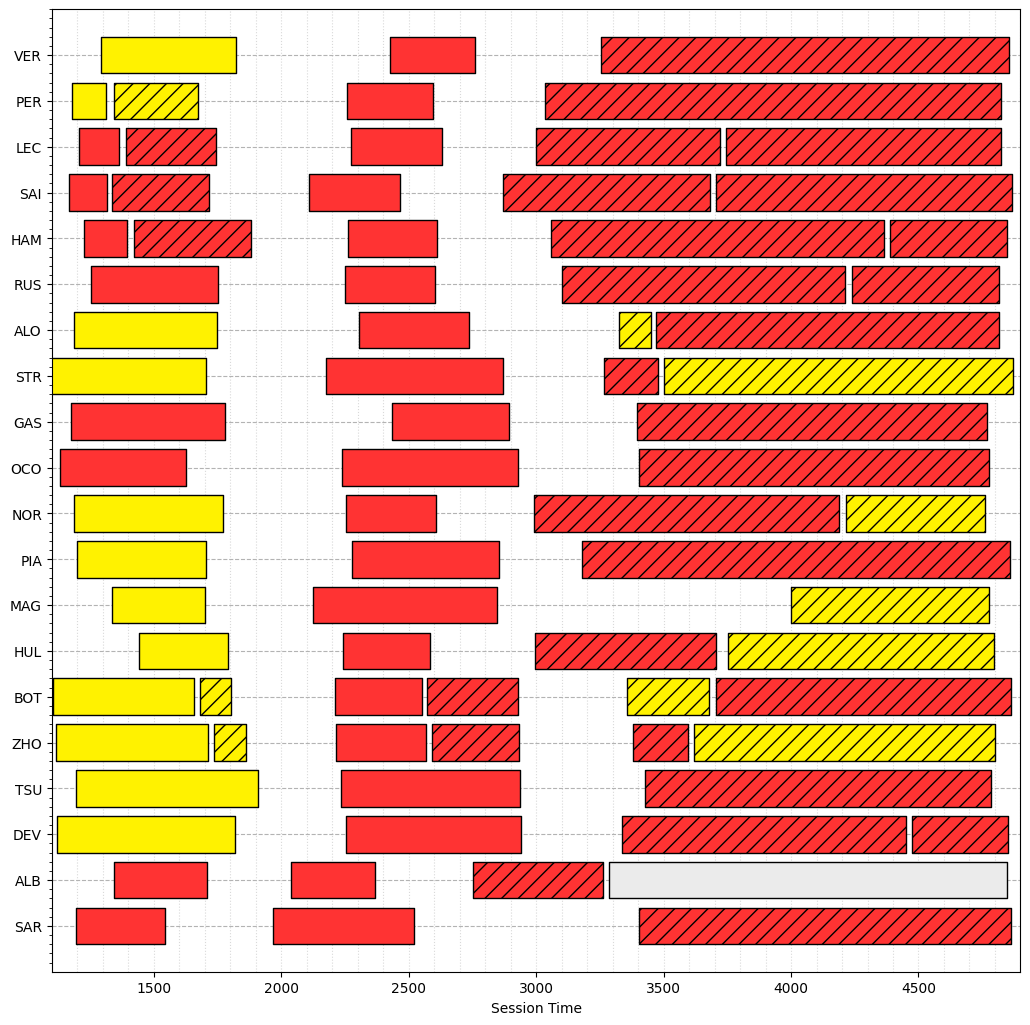

In [12]:

fig, ax = plt.subplots(figsize=(12.5, 12.5))


# starting offset
# this will change depending on whether you adjust the size of the plot
# it basically sets the distance from the bottom of the graph the first bar starts
# we then increment this within each loop to place the next bar an equal distance above

s_offset = 3

# create an array for the drivers. Could have done it programmatically but I wanted the drivers in 
# a custom order rather than driver number
drivers = ['VER', 'PER', 'LEC', 'SAI',
           'HAM', 'RUS', 'ALO', 'STR',
           'GAS', 'OCO', 'NOR', 'PIA',
           'MAG', 'HUL', 'BOT', 'ZHO',
           'TSU', 'DEV', 'ALB', 'SAR']

# reverse the above drivers array because im stupid 
# and forgot the plot starts from the bottom
drivers = drivers[::-1]

# loop through each driver, and plot their stints
for i, drv in enumerate(drivers):
    #print(f'{i} {drv}')
    driver_name = drv
    # set up the filter criteria so the code is tidier and easier to read
    # could be looped better to look on FreshTyre being True/False but this does the job
    ## SOFT
    fscrit = (stints['Driver']==driver_name) & (stints['Compound']=='SOFT') & (stints['FreshTyre']==True) 
    uscrit = (stints['Driver']==driver_name) & (stints['Compound']=='SOFT') & (stints['FreshTyre']==False)
    ## MED
    fmcrit = (stints['Driver']==driver_name) & (stints['Compound']=='MEDIUM') & (stints['FreshTyre']==True)
    umcrit = (stints['Driver']==driver_name) & (stints['Compound']=='MEDIUM') & (stints['FreshTyre']==False) 
    ## HARD
    fhcrit = (stints['Driver']==driver_name) & (stints['Compound']=='HARD') & (stints['FreshTyre']==True) 
    uhcrit = (stints['Driver']==driver_name) & (stints['Compound']=='HARD') & (stints['FreshTyre']==False)
    
    # get the list of stint start time + duration that we created earlier 
    # get it for each tyre and whether tyre is new/old
    # notice the passing of the criteria into the .loc[] function
    
    ## SOFT
    fresh_soft = list(stints.loc[fscrit]['plotter'])
    used_soft = list(stints.loc[uscrit]['plotter'])
    ## MED 
    fresh_med = list(stints.loc[fmcrit]['plotter'])
    used_med = list(stints.loc[umcrit]['plotter'])
    ## HARD 
    fresh_hard = list(stints.loc[fhcrit]['plotter'])
    used_hard = list(stints.loc[uhcrit]['plotter'])
    ## You will need to add some for Inters/Wets if you're looking at a race with those
    
    # Now we plot the actual bars on the graph using broken_barh. 
    # facecolors = the color of the tyre, and hatch is used to draw the lines on the used compounds
    # tyre colors: SOFT #FF3333. MEDIUM #FFF200. HARD #EBEBEB. INTER #39B54A. WET #00AEEF
    ax.broken_barh(fresh_med, (s_offset, 4), facecolors ='#FFF200', edgecolor='black', zorder=2)
    ax.broken_barh(used_med, (s_offset, 4), facecolors ='#FFF200', edgecolor='black', zorder=2, hatch='//')
    ax.broken_barh(fresh_soft, (s_offset, 4), facecolors ='#FF3333',edgecolor='black', zorder=2)
    ax.broken_barh(used_soft, (s_offset, 4), facecolors ='#FF3333',edgecolor='black', zorder=2, hatch='//')
    ax.broken_barh(fresh_hard, (s_offset, 4), facecolors ='#EBEBEB',edgecolor='black', zorder=2)
    ax.broken_barh(used_hard, (s_offset, 4), facecolors ='#EBEBEB',edgecolor='black', zorder=2, hatch='//')
    
    # adjust the offset for the next loop 
    s_offset = s_offset + 5

# configure the remainder of the plot. Find the min and max of the lap times to set the start/end points.
xmin = round(laps['min_time'].min(), -2)
xmax = round(laps['max_time'].max(), -2)
ax.set_xlim(xmin, xmax)
ax.set_xlabel('Session Time')

# set the axis limits for Y (drivers names)
ax.set_ylim(0, 105)
# set the ticks to be every 5
ax.set_yticks([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
ax.set_yticklabels(drivers)

# add some grid lines just to make it easier to read
ax.yaxis.grid(True, which='major', linestyle='--', color=(0.70, 0.70, 0.70))
ax.xaxis.grid(True, which='both', linestyle='dotted', color=(0.85, 0.85, 0.85))

ax.minorticks_on()
ax.tick_params(axis='x', which='minor', bottom=False)
         
plt.show()
